In [1541]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# train test split the data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# import regression algorithms
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import KNNImputer

#import grid search cv for cross validation
from sklearn.model_selection import GridSearchCV

In [1542]:
df1 = pd.read_csv("house_price_bd.csv")
df1.head()

,Title,Bedrooms,Bathrooms,Floor_no,Occupancy_status,Floor_area,City,Price_in_taka,Location
0,We Are Offering You A Very Spacious 1960 Sq Ft...,3.0,4.0,3,vacant,1960.0,dhaka,"৳39,000,000","Gulshan 1, Gulshan"
1,Valuable 1705 Square Feet Apartment Is Ready T...,3.0,3.0,1,vacant,1705.0,dhaka,"৳16,900,000","Lake Circus Road, Kalabagan"
2,1370 square feet apartment is ready to sale in...,3.0,3.0,6,vacant,1370.0,dhaka,"৳12,500,000","Shukrabad, Dhanmondi"
3,2125 Square Feet Apartment For Sale In Bashund...,3.0,3.0,4,vacant,2125.0,dhaka,"৳20,000,000","Block L, Bashundhara R-A"
4,Buy This 2687 Square Feet Flat In The Nice Are...,3.0,3.0,4,vacant,2687.0,dhaka,"৳47,500,000","Road No 25, Banani"


In [1543]:
df1.describe()

,Bedrooms,Bathrooms,Floor_area
count,2864.000000,2864.000000,3766.000000
mean,3.133031,2.992668,1940.299522
std,2.215457,0.978434,6024.921935
min,1.000000,1.000000,84.000000
25%,3.000000,3.000000,1100.000000
50%,3.000000,3.000000,1380.000000
75%,3.000000,3.000000,1860.000000
max,50.000000,10.000000,195840.000000


In [1544]:
df1['City'].unique()

array(['dhaka', 'chattogram', 'cumilla', 'narayanganj-city', 'gazipur'],
      dtype=object)

In [1545]:
df1['City'].value_counts()

City
dhaka               1650
chattogram          1470
narayanganj-city     420
gazipur              180
cumilla              145
Name: count, dtype: int64

In [1546]:
df1['Floor_no'].unique()

array(['3', '1', '6', '4', '8', '2', '5', '7', '9', '8th', nan, '10',
       '14', 'G+7', '13', '12', '1st', '11', 'A1,A2,A3,A4,A5,A6,A7',
       '0+7', '1F', '4th to 8th Backside', '18', '5th', '17',
       'Merin City - Purbach'], dtype=object)

## Handling Floor_no column

In [1548]:
import re
def floor(floor_value):
    if pd.isna(floor_value):
        return np.nan

    # Ensure the value is a string
    floor_value = str(floor_value)
    
    # Handle 'G' as 1 and 'G+X' as 1 + X
    if 'G' in floor_value:
        if '+' in floor_value:
            parts = floor_value.split('+')
            try:
                return 1 + int(parts[-1])
            except ValueError:
                return np.nan
        elif floor_value.strip() == 'G':
            return 1
    
    # Remove suffixes like 'th', 'st', 'nd', 'rd'
    floor_value = re.sub(r'(th|st|nd|rd)\b', '', floor_value)
    
    # Extract a single number if present
    if re.search(r'\d+', floor_value):
        number = re.search(r'\d+', floor_value).group()
        return int(number)
    
    # Handle ranges like '4 to 8' by calculating the median
    if 'to' in floor_value:
        try:
            start, end = map(int, re.findall(r'\d+', floor_value))
            return (start + end) // 2
        except (ValueError, IndexError):
            return np.nan
    
    # Handle invalid cases with ',' or ' '
    if ',' in floor_value or ' ' in floor_value:
        return np.nan
    
    return np.nan

df1['Floor_no'] = df1['Floor_no'].apply(floor)

In [1549]:
df1['Floor_no'].unique()

array([ 3.,  1.,  6.,  4.,  8.,  2.,  5.,  7.,  9., nan, 10., 14., 13.,
       12., 11.,  0., 18., 17.])

In [1550]:
df1.isnull().sum()

Title                  0
Bedrooms            1001
Bathrooms           1001
Floor_no             690
Occupancy_status      99
Floor_area            99
City                   0
Price_in_taka          0
Location               6
dtype: int64

In [1551]:
df1['Price_in_taka'] = df1['Price_in_taka'].str.replace('৳', '').str.replace(',', '').astype('int64')

In [1552]:
df1["Price_in_taka"].head()

0    39000000
1    16900000
2    12500000
3    20000000
4    47500000
Name: Price_in_taka, dtype: int64

In [1553]:
# Convert the values of Price_in_taka into millions.
df1['Price_in_taka'] = df1['Price_in_taka'] / 1000000
# chane the column name price_in_taka into Price_in_taka(M)
df1 = df1.rename(columns = {'Price_in_taka': 'Price_in_taka(Mils)'})

In [1554]:
df1.describe()

,Bedrooms,Bathrooms,Floor_no,Floor_area,Price_in_taka(Mils)
count,2864.000000,2864.000000,3175.000000,3766.000000,3865.000000
mean,3.133031,2.992668,4.445354,1940.299522,12.563107
std,2.215457,0.978434,2.676902,6024.921935,29.112108
min,1.000000,1.000000,0.000000,84.000000,0.000066
25%,3.000000,3.000000,2.000000,1100.000000,4.900000
50%,3.000000,3.000000,4.000000,1380.000000,7.000000
75%,3.000000,3.000000,6.000000,1860.000000,11.000000
max,50.000000,10.000000,18.000000,195840.000000,532.000000


## Handling missing values

In [1556]:
# checking missing values
df1.isnull().sum()

Title                     0
Bedrooms               1001
Bathrooms              1001
Floor_no                690
Occupancy_status         99
Floor_area               99
City                      0
Price_in_taka(Mils)       0
Location                  6
dtype: int64

In [1557]:
columns_to_drop_missing_values = ['Floor_area', 'Location', 'Floor_no']

# Remove rows with missing values in the specified columns
df1 = df1.dropna(subset=columns_to_drop_missing_values, axis = 0)
# verify the result
df1.isnull().sum()

Title                    0
Bedrooms               343
Bathrooms              343
Floor_no                 0
Occupancy_status         0
Floor_area               0
City                     0
Price_in_taka(Mils)      0
Location                 0
dtype: int64

## Impute missing values

In [1559]:
# Impute the missing values in Bathrooms and Bedrooms using Floor area
from sklearn.impute import KNNImputer
features = ['Floor_area', 'Bedrooms', 'Bathrooms']

imputer = KNNImputer(n_neighbors=5, weights='distance')
df1[features] = imputer.fit_transform(df1[features])
df1.isnull().sum()

Title                  0
Bedrooms               0
Bathrooms              0
Floor_no               0
Occupancy_status       0
Floor_area             0
City                   0
Price_in_taka(Mils)    0
Location               0
dtype: int64

In [1560]:
# Change the data type of the Columns "Bedrooms", "Bathrooms", "Floor_no"
df1['Bedrooms'] = df1['Bedrooms'].astype("int64")
df1['Bathrooms'] = df1['Bathrooms'].astype("int64")
df1['Floor_no'] = df1['Floor_no'].astype("int64")

In [1561]:
location_stats = df1.groupby('Location')['Location'].agg('count').sort_values(ascending = False)
location_stats

Location
Dewan Bazar, Bakalia                            98
Dhaka Trunk Road, 9 No. North Pahartali Ward    73
Joydebpur, Gazipur Sadar Upazila                66
24 No. North Agrabad Ward, Double Mooring       50
Section 10, Mirpur                              49
                                                ..
Salimullah Road, Mohammadpur                     1
Sadarghat Road, 33 No. Firingee Bazaar Ward      1
Sadar Hospital Road, Monohorpur                  1
City Gate, 10 No. North Kattali Ward             1
aziz Moholla, Mohammadpur                        1
Name: Location, Length: 446, dtype: int64

In [1562]:
location_stats_less_than_5 = location_stats[location_stats <= 5]
location_stats_less_than_5

Location
Jahuri Moholla, Mohammadpur                        5
Jigatola, Hazaribag                                5
Jangalpara, 7 No. West Sholoshohor Ward            5
Port Connecting Road, 11 No. South Kattali Ward    5
Madina Masjid Road, Thakur Para                    5
                                                  ..
Salimullah Road, Mohammadpur                       1
Sadarghat Road, 33 No. Firingee Bazaar Ward        1
Sadar Hospital Road, Monohorpur                    1
City Gate, 10 No. North Kattali Ward               1
aziz Moholla, Mohammadpur                          1
Name: Location, Length: 289, dtype: int64

In [1563]:
df1.Location = df1.Location.apply(lambda x: 'other' if x in location_stats_less_than_5 else x)
len(df1.Location.unique())

158

## Dropping duplicate rows

In [1565]:
# remove duplicates, keeping the last occurrence
df1 = df1.drop_duplicates(keep='last')

In [1566]:
df1.duplicated().sum()

0

In [1567]:
df1.describe()

,Bedrooms,Bathrooms,Floor_no,Floor_area,Price_in_taka(Mils)
count,2349.000000,2349.000000,2349.000000,2349.000000,2349.000000
mean,2.955726,2.852703,4.562367,1463.186462,11.304496
std,1.888208,1.080459,2.710013,1395.070470,22.322902
min,1.000000,1.000000,0.000000,84.000000,1.050000
25%,3.000000,2.000000,2.000000,1075.000000,5.000000
50%,3.000000,3.000000,4.000000,1316.000000,7.000000
75%,3.000000,3.000000,6.000000,1570.000000,11.000000
max,46.000000,10.000000,18.000000,24000.000000,363.200000


## Removing Outliers

In [1569]:
df1[df1.Floor_area/df1.Bedrooms<200].head() # checking for rooms less than 200 sqft

,Title,Bedrooms,Bathrooms,Floor_no,Occupancy_status,Floor_area,City,Price_in_taka(Mils),Location
1019,Acquire This 130 Sq Ft Shop Which Is Up For Sa...,1,1,2,vacant,130.0,dhaka,4.200,other
1733,Close To Chattogram International Medical Coll...,1,1,1,vacant,135.0,chattogram,2.430,"Chand Mia Road, 4 No Chandgaon Ward"
1745,Shop Space Up For Sale In Bahaddarhat Nearby J...,1,1,4,vacant,157.0,chattogram,4.082,"CDA Avenue, Sholokbahar"
1811,"AT Dhaka Trunk Road, 9 No. North Pahartali War...",1,1,1,vacant,105.0,chattogram,3.675,"Dhaka Trunk Road, 9 No. North Pahartali Ward"
1812,Get The Commercial Benefits In This 110 Sq Ft ...,1,1,1,vacant,110.0,chattogram,3.850,"Dhaka Trunk Road, 9 No. North Pahartali Ward"


In [1570]:
df1 = df1[~(df1.Floor_area/df1.Bedrooms<200)] # removing rooms less than 200 sqft
df1.shape

(2195, 9)

In [1571]:
df1['price_per_sqft'] = df1['Price_in_taka(Mils)']*1000000/df1['Floor_area']
df1.head()

,Title,Bedrooms,Bathrooms,Floor_no,Occupancy_status,Floor_area,City,Price_in_taka(Mils),Location,price_per_sqft
214,An Apartment For Sale Is All Set For You To Se...,3,3,8,vacant,1100.0,dhaka,4.70,other,4272.727273
215,A Flat With All Facilities Is Up For Sale At W...,3,2,2,vacant,1220.0,dhaka,5.00,"West Shewrapara, Mirpur",4098.360656
216,1240 Square Feet Flat For Sale In The Location...,3,3,5,vacant,1240.0,dhaka,7.32,"Section 1, Mirpur",5903.225806
217,1700 Sq.Ft. Apartment For Sale In Dakshin Khan...,3,3,5,vacant,1700.0,dhaka,6.50,"South Chalabon, Dakshin Khan",3823.529412
218,Flat For Sale Covering A Beautiful Area In Wes...,3,3,1,vacant,1400.0,dhaka,8.50,"West Agargaon, Agargaon",6071.428571


In [1572]:
df1.describe()

,Bedrooms,Bathrooms,Floor_no,Floor_area,Price_in_taka(Mils),price_per_sqft
count,2195.000000,2195.000000,2195.000000,2195.00000,2195.000000,2195.000000
mean,3.092938,2.982688,4.703872,1556.61139,11.839496,6707.435881
std,1.878371,0.995739,2.717437,1396.27863,22.995562,4023.260664
min,1.000000,1.000000,0.000000,200.00000,1.300000,2200.000000
25%,3.000000,3.000000,2.000000,1142.50000,5.334000,4500.000000
50%,3.000000,3.000000,5.000000,1350.00000,7.300000,5571.428571
75%,3.000000,3.000000,7.000000,1600.00000,11.014100,7336.391437
max,46.000000,10.000000,18.000000,24000.00000,363.200000,45000.000000


Text(0, 0.5, 'Count')

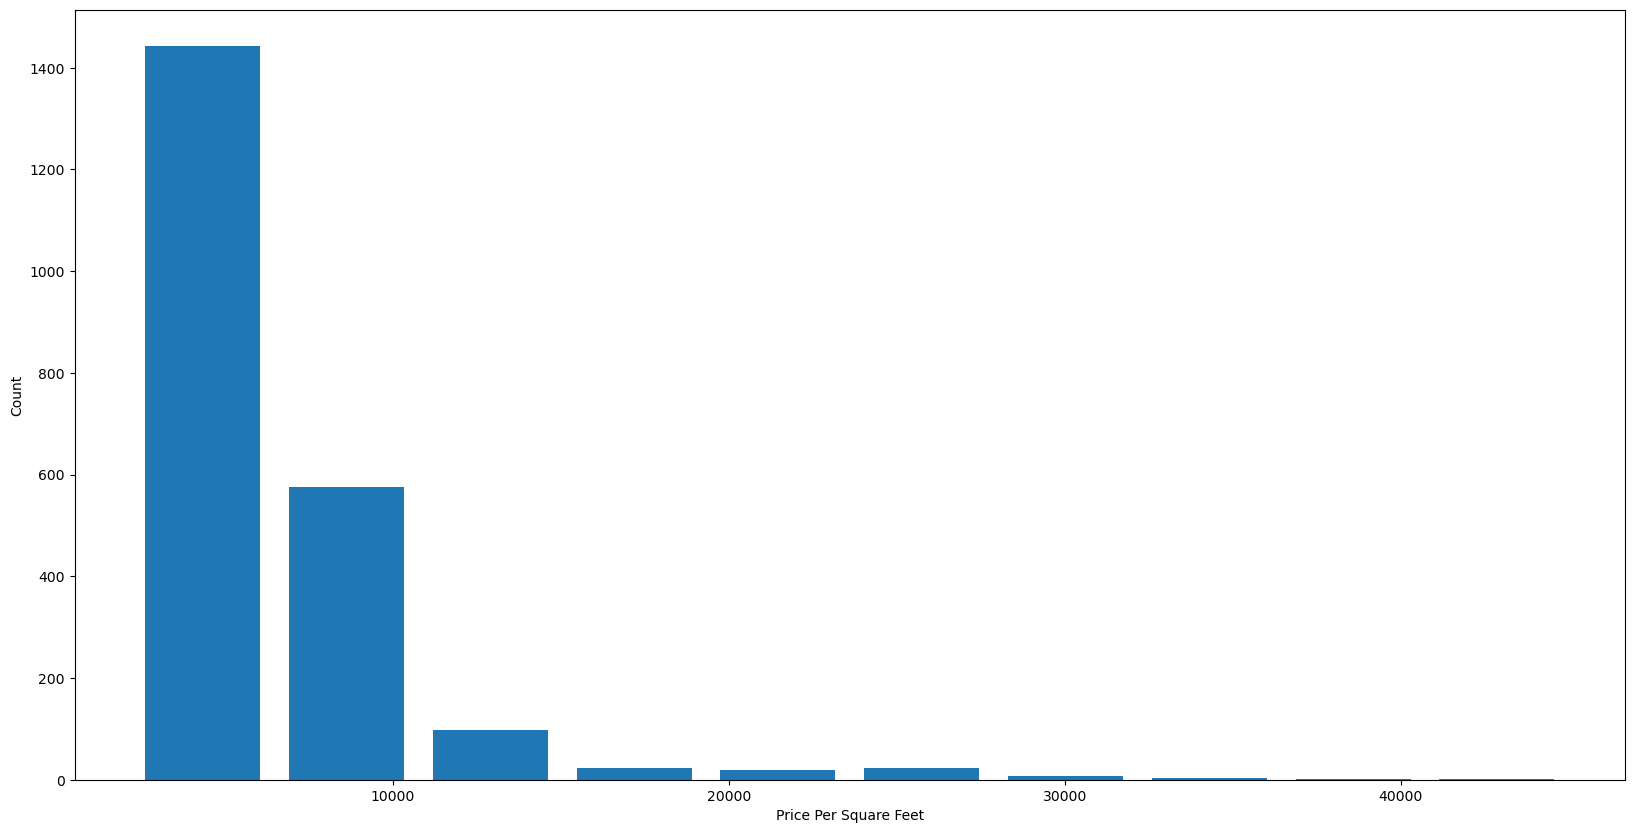

In [1573]:
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df1.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

In [1574]:
def remove_pps_outliers(df): # removing price per sqft outliers with one std
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('Location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df1 = remove_pps_outliers(df1)
df1.shape

(1667, 10)

## Correlation Matrix

In [1576]:
import plotly.graph_objects as go
# Select numerical columns for correlation
numeric_cols = ['Bedrooms', 'Bathrooms', 'Floor_no', 'Floor_area', 'Price_in_taka(Mils)']

# Calculate the correlation matrix
corr_matrix = df1[numeric_cols].corr()

# Create the heatmap
fig = go.Figure(data=go.Heatmap(
                z=corr_matrix.values,
                x=corr_matrix.columns,
                y=corr_matrix.columns,
                colorscale='RdBu',
                zmin=-1, zmax=1,
                text=np.round(corr_matrix.values, decimals=2),
                texttemplate="%{text}",
                textfont={"size":10},
                hoverongaps = False))

# Update the layout
fig.update_layout(
    title='Correlation Matrix of Numeric Features',
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    xaxis_side='top'
)

# Show the plot
fig.show()

## Checking Outliers

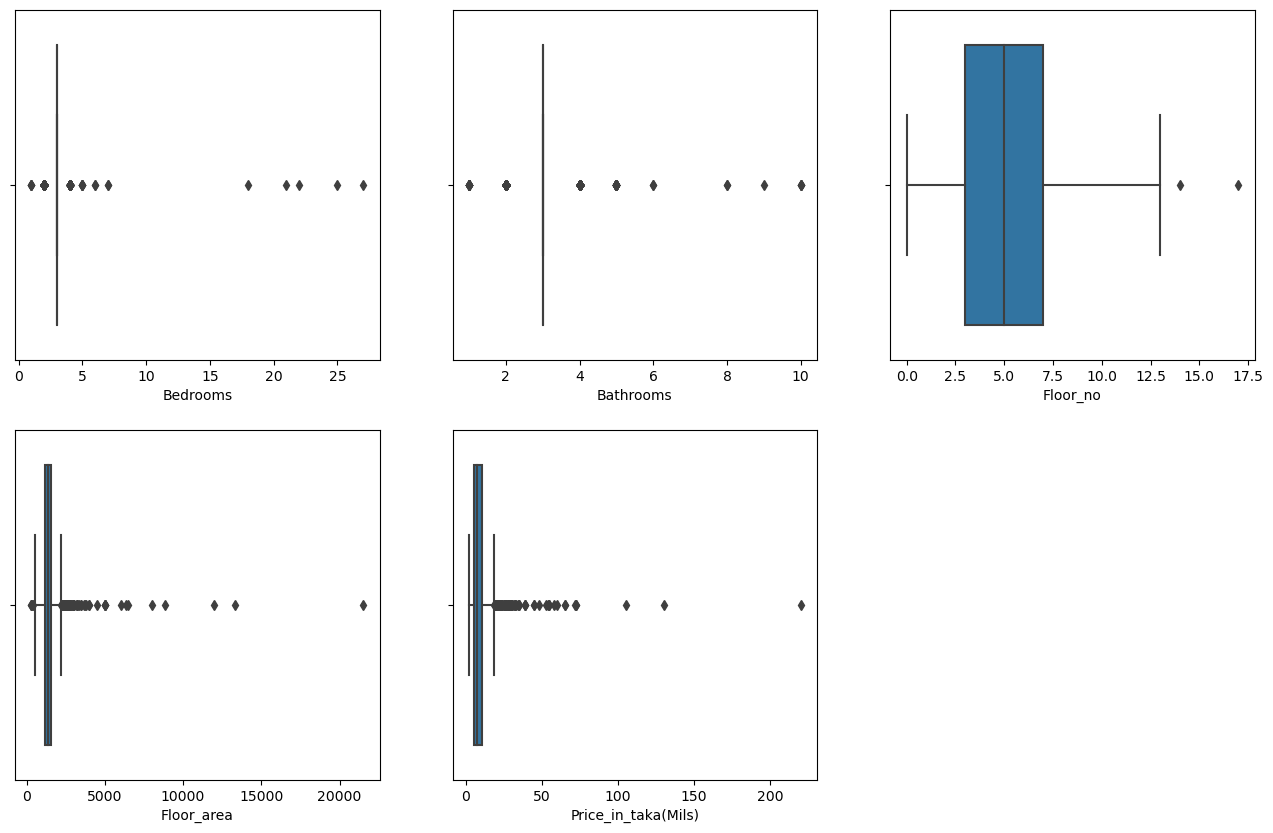

In [1578]:
# To identify the outliers using boxplot
columns = ['Bedrooms', 'Bathrooms', 'Floor_no', 'Floor_area', 'Price_in_taka(Mils)']
plt.figure(figsize=(16, 10))
for i, col in enumerate(columns):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x = col, data = df1)
plt.show()

## One Hot Encoding

In [1580]:
from sklearn.preprocessing import OneHotEncoder
# One Hot Encoding
df1 = pd.get_dummies(df1, columns=['City', 'Location'], drop_first=True)

# Convert all columns to int
for col in df1.columns:
    if df1[col].dtype == bool:
        df1[col] = df1[col].astype(int)

In [1581]:
df1.head()

,Title,Bedrooms,Bathrooms,Floor_no,Occupancy_status,Floor_area,Price_in_taka(Mils),price_per_sqft,City_cumilla,City_dhaka,...,"Location_West Kazipara, Mirpur","Location_West Khulshi R/A, 9 No. North Pahartali Ward","Location_West Khulshi, 9 No. North Pahartali Ward","Location_West Monipur, Mirpur","Location_West Rampura, Rampura","Location_West Shewrapara, Mirpur","Location_Yakub Future Park Housing, Khulshi","Location_Yakub Nagar Road, 33 No. Firingee Bazaar Ward","Location_Zakir Hossain Road, Khulshi",Location_other
0,See This Flat Of 1000 Sq Ft As Your Dream Home...,3,3,3,vacant,1000.0,4.0,4000.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1150 Square Feet And 2 Bedroom Flat Is For Sal...,2,2,4,vacant,1150.0,4.6,4000.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Check This Fine Looking Flat Of 1150 Sq Ft Off...,2,2,4,vacant,1150.0,4.6,4000.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Visit This 1050 Sq.ft Flat is For Sale At Paha...,2,2,5,vacant,1050.0,4.2,4000.0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Your Desired Large 2 Bedroom Home In Pahartali...,2,2,1,vacant,1150.0,4.6,4000.0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1582]:
df1.shape

(1667, 163)

In [1583]:
df1 = df1.drop(['Title', 'Occupancy_status'], axis=1)
df1.head()

,Bedrooms,Bathrooms,Floor_no,Floor_area,Price_in_taka(Mils),price_per_sqft,City_cumilla,City_dhaka,City_gazipur,City_narayanganj-city,...,"Location_West Kazipara, Mirpur","Location_West Khulshi R/A, 9 No. North Pahartali Ward","Location_West Khulshi, 9 No. North Pahartali Ward","Location_West Monipur, Mirpur","Location_West Rampura, Rampura","Location_West Shewrapara, Mirpur","Location_Yakub Future Park Housing, Khulshi","Location_Yakub Nagar Road, 33 No. Firingee Bazaar Ward","Location_Zakir Hossain Road, Khulshi",Location_other
0,3,3,3,1000.0,4.0,4000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,2,4,1150.0,4.6,4000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2,4,1150.0,4.6,4000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,2,5,1050.0,4.2,4000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,2,1,1150.0,4.6,4000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Building Models

In [1585]:
from sklearn.model_selection import train_test_split
# Split the data into features and target
X = df1.drop("Price_in_taka(Mils)", axis = 1)
y = df1["Price_in_taka(Mils)"]

In [1586]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [1587]:
# Create a dictionaries of list of models to evaluate performance 
models = { 
          'LinearRegression' : (LinearRegression(), {}),
          'SVR' : (SVR(), {}),
          'DecisionTreeRegressor' : (DecisionTreeRegressor(criterion = "absolute_error", random_state = 42), {}),
          'RandomForestRegressor' : (RandomForestRegressor(n_estimators=100, random_state=42), {}),
          'KNeighborsRegressor' : (KNeighborsRegressor(n_neighbors=100), {}),
          'GradientBoostingRegressor' : (GradientBoostingRegressor(), {}),
          'XGBRegressor' : (XGBRegressor(), {})
                
          }


# train and predict each model with evaluation metrics as well making a for loop to iterate over the models

for name, (model, params) in models.items():
    # create a pipline
    pipeline = GridSearchCV(model, params, cv=5)
    
    # fit the pipeline
    pipeline.fit(X_train, y_train)
    
    # make prediction from each model
    y_pred = pipeline.predict(X_test)
    
      
    # print the performing metric
    print(name, 'MSE: ', mean_squared_error(y_test, y_pred))
    print(name, 'R2: ', r2_score(y_test, y_pred))
    print('\n')

LinearRegression MSE:  4.417838026509267
LinearRegression R2:  0.9448474828043484


SVR MSE:  22.601764664757237
SVR R2:  0.7178384071925685


DecisionTreeRegressor MSE:  2.4863141735029934
DecisionTreeRegressor R2:  0.968960725951226


RandomForestRegressor MSE:  3.86453706100767
RandomForestRegressor R2:  0.9517549205218668


KNeighborsRegressor MSE:  30.585354733943255
KNeighborsRegressor R2:  0.6181708580584215


GradientBoostingRegressor MSE:  1.981899294245323
GradientBoostingRegressor R2:  0.9752578672531634


XGBRegressor MSE:  3.879944995862308
XGBRegressor R2:  0.9515625670704907




## Evaluating good performing models

In [1589]:
gb_clf = GradientBoostingRegressor()
gb_clf.fit(X_train,y_train)
gb_clf.score(X_test,y_test)

0.9749455883922837

In [1590]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cross_val_score(GradientBoostingRegressor(), X, y, cv=cv)

array([0.98292906, 0.98668233, 0.99075706, 0.98435034, 0.93620587])

In [1591]:
rf_clf = RandomForestRegressor()
rf_clf.fit(X_train,y_train)
rf_clf.score(X_test,y_test)

0.9480409964208963

In [1592]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cross_val_score(RandomForestRegressor(), X, y, cv=cv)

array([0.95295546, 0.96830943, 0.97495359, 0.95163816, 0.89800956])

## Predicting Prices

In [1594]:
def predict_price_mils(location, bed, bath, floor, area):    
    # Generate the one-hot encoded column name
    loc_column = f'Location_{location}'
    
    # Check if the generated column exists in X.columns
    if loc_column not in X.columns:
        raise ValueError(f"Location '{location}' not found in one-hot encoded columns.")
    
    # Initialize the input array with zeros
    x = np.zeros(len(X.columns))
    x[0] = bed
    x[1] = bath
    x[2] = floor
    x[3] = area
    # Set the corresponding location column to 1
    loc_index = np.where(X.columns == loc_column)[0][0]
    x[loc_index] = 1
    # Convert to a DataFrame with the correct column names
    x_df = pd.DataFrame([x], columns=X.columns)
    return gb_clf.predict(x_df)[0]

    return gb_clf.predict([x])[0]

In [1595]:
predict_price('West Shewrapara, Mirpur', 3, 3, 2, 1450)

5.249121457309688

## Saving Model

In [1597]:
import pickle
# Save the model
with open('bdhp.pkl', 'wb') as file:
    pickle.dump(model, file)

## json file

In [1599]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as file:
    file.write(json.dumps(columns))